In [1]:
import time
from dataclasses import dataclass
from typing import *

import matplotlib
import matplotlib.animation
import matplotlib.patches
import matplotlib.pyplot as plt
import torch
from torch import Tensor, nn

In [2]:
EX = torch.tensor([1., 0.])
EY = torch.tensor([0., 1.])

@dataclass
class State:
    # Variables
    ball: Tensor
    ball_v: Tensor
    paddles: Tensor  # (2, 2)
    outcome: Tensor  # 0 = playing, +1 = player0 wins, -1 = player1 wins
    # Constants
    dt: float
    bounds: Tensor  # [[xmin, ymin], [xmax, ymax]]
    paddle_speed: float
    paddle_width: float
    bounce_acceleration: float

    def update(self, control: Tensor) -> None:
        dt = self.dt * (self.outcome == 0)
        # Update
        self.paddles.add_(dt * self.paddle_speed * control[:, None] * EX).clip_(*self.bounds)
        self.ball.add_(dt * self.ball_v)
        # End of game
        oob_lo = (self.ball < self.bounds[0])
        oob_hi = (self.bounds[1] < self.ball)
        win0 = oob_hi[1] & ((self.paddle_width/2) < (self.paddles[1, 0] - self.ball[0]).abs_())
        win1 = oob_lo[1] & ((self.paddle_width/2) < (self.paddles[0, 0] - self.ball[0]).abs_())
        self.outcome = self.outcome | (win0.long() - win1.long())
        # Bounce
        self.ball_v *= 1 - (2 + self.bounce_acceleration) * (oob_lo | oob_hi)
        self.ball.clip_(*self.bounds)

    @classmethod
    def init(cls) -> "State":
        return cls(
            ball=torch.tensor([0., 0.]),
            ball_v=torch.tensor([torch.rand(()).round() * 2 - 1, torch.rand(()) * 4 - 2]),
            paddles=torch.tensor([[0., -1.], [0., 1.]]),
            outcome=torch.tensor(0),
            dt=0.02,
            bounds=torch.tensor([[-.5, -1], [.5, 1.]]),
            paddle_speed=2,
            paddle_width=0.2,
            bounce_acceleration=0.2,
        )

@dataclass
class Render:
    figure: matplotlib.figure.Figure
    ball: matplotlib.patches.Circle
    paddle0: matplotlib.patches.Rectangle
    paddle1: matplotlib.patches.Rectangle

    @property
    def ax(self) -> matplotlib.axes.Axes:
        return self.figure.gca()

    def update(self, state: State) -> None:
        self.ball.set_center(state.ball)
        self.paddle0.set_xy(state.paddles[0] - state.paddle_width/2 * EX - self.paddle0.get_height()/2)
        self.paddle1.set_xy(state.paddles[1] - state.paddle_width/2 * EX - self.paddle1.get_height()/2)

    @classmethod
    def init(cls, state: State) -> "Render":
        render = cls(
            figure=plt.figure(figsize=(8, 8), clear=True),
            ball=matplotlib.patches.Circle([0, 0], 0.02, color="#f00"),
            paddle0=matplotlib.patches.Rectangle([0, 0], state.paddle_width, 0.04, color="#0a0"),
            paddle1=matplotlib.patches.Rectangle([0, 0], state.paddle_width, 0.04, color="#00f"),
        )
        plt.close()
        for a in render.__dict__.values():
            if a is not render.figure:
                render.ax.add_patch(a)
        render.ax.set_xlim(state.bounds[:, 0])
        render.ax.set_ylim(state.bounds[:, 1])
        render.ax.set_xticks([])
        render.ax.set_yticks([])
        render.ax.set_aspect("equal")
        render.update(state)
        return render

Agent = Callable[[State], Tensor]

def script_agent(player: int) -> Agent:
    return lambda state: 2 * (state.paddles[player, 0] < state.ball[0]) - 1

@dataclass
class Log:
    ball: List[Tensor]
    paddles: List[Tensor]
    control: List[Tensor]

    def update(self, state: State, control: Tensor) -> None:
        self.ball.append(state.ball.clone())
        self.paddles.append(state.paddles.clone())
        self.control.append(control.clone())

def play(p0: Agent, p1: Agent) -> Log:
    state = State.init()
    render = Render.init(state)
    log = Log([], [], [])
    h = display(render.figure, display_id="game", clear=True)
    for _ in range(300):
        control = torch.stack([p0(state), p1(state)])
        log.update(state, control)
        state.update(control)
        render.update(state)
        time.sleep(state.dt)
        h.update(render.figure)
        if state.outcome.item():
            break
    return log

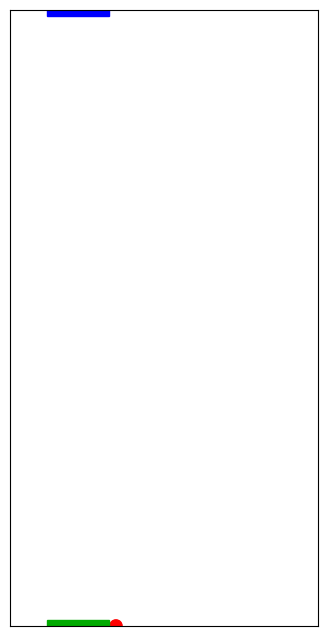

In [3]:
log = play(script_agent(0), script_agent(1))
data_state = torch.concat([torch.stack(log.ball), torch.stack(log.paddles)[:, 0, :1]], -1)
data_control = torch.stack(log.control)[:, 0]

In [4]:
class Model(nn.Module):
    def __init__(self, hidden_size: int, n_buckets: int):
        super().__init__()
        self.n_buckets = n_buckets
        self.hidden_size = hidden_size
        self.embed = nn.Parameter(torch.randn(n_buckets, 3, hidden_size))
        self.mlp = nn.Sequential(
            nn.Linear(3 * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 3)
        )

    def forward(self, state: Tensor) -> Tensor:
        """
        state -- (batch, [ball_x, ball_y, paddle_x])
        """
        embed_index = ((state + 1) * 0.5 * (self.n_buckets - 1)).clip_(0, self.n_buckets - 1).round_().long()
        hidden = self.embed.gather(0, embed_index[:, :, None].expand(embed_index.shape + (self.hidden_size,)))
        hidden = hidden.flatten(start_dim=1)
        return self.mlp(hidden)

    def loss_accuracy(self, state: Tensor, control: Tensor) -> Tuple[Tensor, Tensor]:
        logits = self(state)
        loss = nn.functional.cross_entropy(logits, control + 1)
        accuracy = (logits.argmax(-1) == (control + 1)).float().mean()
        return loss, accuracy

    def agent(self, player: int) -> Agent:
        def _act(state: State) -> Tensor:
            state_v = torch.concat([state.ball, state.paddles[player, :1]])
            state_v[1] *= 1 - 2 * (player == 1)
            logits = self(state_v[None])[0]
            return logits.argmax() - 1
        return _act

model = Model(hidden_size=32, n_buckets=20)
opt = torch.optim.Adam(model.parameters(), 0.01)
# opt = torch.optim.SGD(model.parameters(), 0.5)
for i in range(101):
    opt.zero_grad()
    loss, accuracy = model.loss_accuracy(data_state, data_control)
    if i % 10 == 0:
        print(f"{i:<3d}   {loss:.3f}   {accuracy:.0%}")
    loss.backward()
    opt.step()

0     1.121   26%
10    0.520   77%
20    0.280   89%
30    0.186   91%
40    0.161   91%
50    0.156   91%
60    0.155   91%
70    0.155   91%
80    0.154   91%
90    0.154   91%
100   0.154   91%


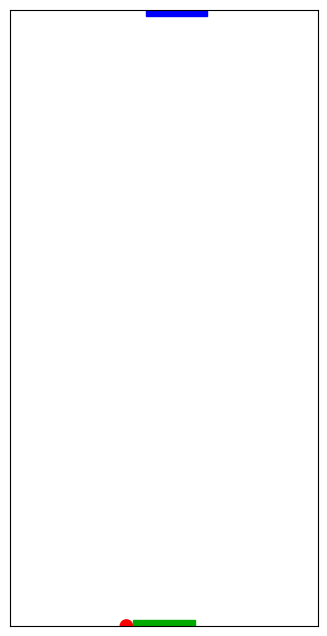

In [5]:
play(model.agent(0), model.agent(1));